### Initial Data Set Up

In [60]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import ta
from ta import momentum
import ccxt
import hvplot
import hvplot.pandas
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from datetime import datetime, timedelta, timezone, date

%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Get data from Binance exchange
exchange_class = getattr(ccxt,'binance') #note data pulling from Binance
exchange = exchange_class({
    'apiKey': '',
    'secret': '',
    'timeout': 30000,
    'enableRateLimit': True,
})

In [61]:
# Data function to get data depending on timeframe
def get_symbol_history(symbol,timeframe,start_date,end_date):
    
    if time_frame == '15m':
        # 1000 x 15m = 10 days
        freq = '10D'
    elif time_frame == '1h':
        # 1000 hours = 41 days
        freq = '41D'
    elif time_frame == '4h':
        # 1000 x 4h = 3 years
        freq = '166D'
    elif time_frame == '1d':
        # 1000 x 1d = 3 years
        freq = '3Y'
    
    period_starts = list(pd.date_range(start=start_date, end=end_date,freq=freq,tz='UTC').astype(np.int64))
    
    df = pd.DataFrame()
    for month in period_starts:
        since = int(month/1000000)
        new_df = pd.DataFrame(exchange.fetch_ohlcv(symbol, time_frame,since=since,limit=1000))
        if len(new_df) > 0:
            df = df.append(new_df)
    if len(df)>0:
        header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = header
    
    df = df.drop_duplicates() 
    df.reset_index(drop=True) 

    df.index = pd.to_datetime(df['Timestamp'],unit='ms')
    df.drop(columns = ['Timestamp'],inplace=True)
    
    return df

In [62]:
# Set data date range, timeframe and trading pair/ symbol
start_date = '16/07/2018' #3Y 'long term model' example
end_date = '15/07/2021'
time_frame = '1d' 
symbol = 'BTC/USDT'

raw_df = get_symbol_history(symbol,time_frame,start_date,end_date)

In [63]:
btc_df = raw_df.copy()

In [64]:
btc_df.tail()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2021-07-15,32820.03,33185.25,31133.00,31880.00,51639.576353
2021-07-16,31874.49,32249.18,31020.00,31383.87,48499.864154
2021-07-17,31383.86,31955.92,31164.31,31520.07,34012.242132
2021-07-18,31520.07,32435.00,31108.97,31778.56,35923.716186
2021-07-19,31778.57,31899.00,31261.10,31278.30,14279.347955


In [65]:
# Drop NAs and calculate daily percent return
btc_df["hourly_return"] = btc_df["Close"].dropna().pct_change()
btc_df["target"] = btc_df["Close"].dropna().pct_change(7) #to capture change in last 24hrs or units of time (for short term 24hrs, long term 7 days)

# Display sample data
btc_df.head(5)

,Open,High,Low,Close,Volume,hourly_return,target
Timestamp,,,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350,NaN,NaN
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,0.025450,NaN
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,0.016175,NaN
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,-0.023786,NaN
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,0.006698,NaN


### Moving Averages Indicator

In [66]:
# Set short and long windows
short_window = 3
long_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_close"] = btc_df["Close"].ewm(halflife=short_window).mean()
btc_df["slow_close"] = btc_df["Close"].ewm(halflife=long_window).mean()

# Crossover trading indicator
btc_df["crossover_long"] = np.where(btc_df["fast_close"] > btc_df["slow_close"], 1.0, 0.0)
btc_df["crossover_short"] = np.where(btc_df["fast_close"] < btc_df["slow_close"], -1.0, 0.0)
btc_df["crossover_signal"] = btc_df["crossover_long"] + btc_df["crossover_short"]

btc_df.head(10)

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Timestamp,,,,,,,,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350,NaN,NaN,3702.900000,3702.900000,0.0,0.0,0.0
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,0.025450,NaN,3755.439428,3751.652401,1.0,0.0,1.0
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,0.016175,NaN,3797.986868,3789.784883,1.0,0.0,1.0
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,-0.023786,NaN,3787.312967,3783.422624,1.0,0.0,1.0
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,0.006698,NaN,3788.727518,3785.386039,1.0,0.0,1.0
2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.667751,-0.005551,NaN,3783.840279,3782.546715,1.0,0.0,1.0
2019-01-06,3771.12,4027.71,3740.00,3987.60,36553.806709,0.057450,NaN,3836.281448,3818.266831,1.0,0.0,1.0
2019-01-07,3987.62,4017.90,3921.53,3975.45,31869.846264,-0.003047,0.073604,3870.358674,3842.996224,1.0,0.0,1.0
2019-01-08,3976.76,4069.80,3903.00,3955.13,38901.423122,-0.005111,0.041608,3890.345279,3859.176032,1.0,0.0,1.0


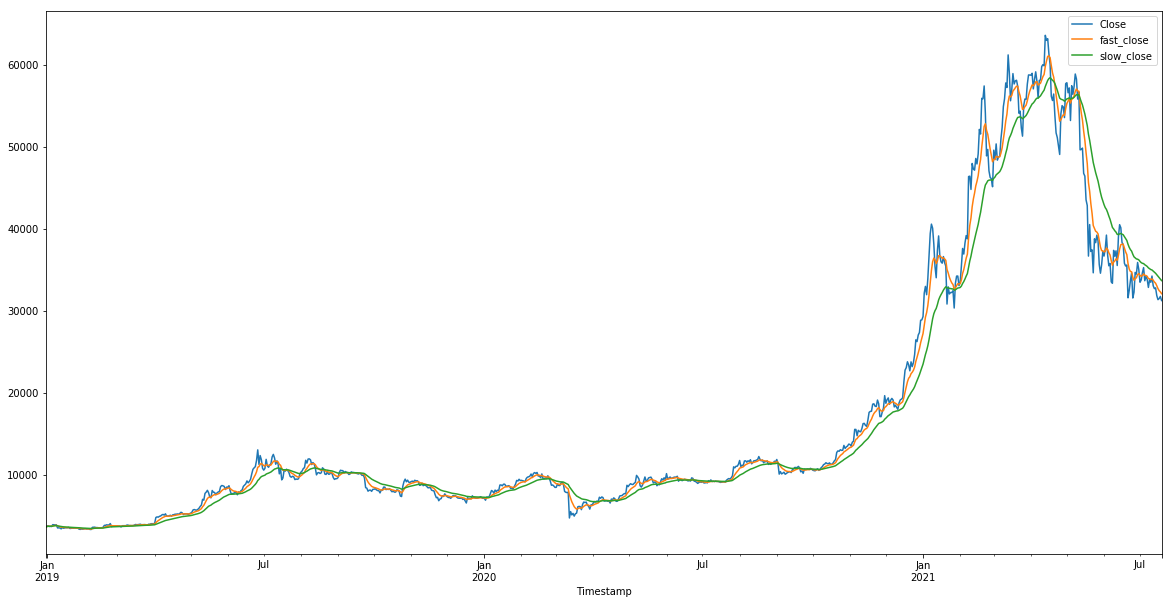

In [67]:
# Plot EMA of BTC/USD closing prices
btc_df[["Close", "fast_close", "slow_close"]].plot(figsize=(20,10))

### Simple Moving Average

In [68]:
short_window = 7
long_window = 30

btc_df['ma_short'] = btc_df['Close'].rolling(window=short_window).mean()
btc_df['ma_long'] = btc_df['Close'].rolling(window=long_window).mean()

btc_df['ma_signal'] = 0
btc_df['ma_signal'] = np.where(btc_df['ma_short']>btc_df['ma_long'],1,0)
btc_df['Entry/Exit'] = btc_df['ma_signal'].diff()

In [69]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['ma_short', 'ma_long']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

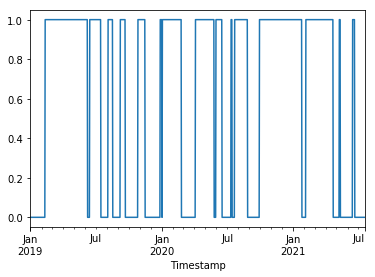

In [70]:
# Showing Bitcoin position at any time
btc_df['Entry/Exit'].cumsum().plot()

In [71]:
# Entry/ Exit and rolling portfolio performance
initial_capital = 10000
size = 1.0 #could use only a portion of the capital for this strategy and split between strategies simultaneously

btc_df['Portfolio Holdings'] = size * btc_df['Close'] * btc_df['Entry/Exit'].cumsum()
btc_df['Portfolio Cash'] = initial_capital - (size * btc_df['Close'] * btc_df['Entry/Exit']).cumsum()
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

btc_df.tail()

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,crossover_signal,ma_short,ma_long,ma_signal,Entry/Exit,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Returns,Portolio Cumulative Returns
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-15,32820.03,33185.25,31133.00,31880.00,51639.576353,-0.028642,-0.030287,33079.305629,34416.764349,0.0,...,-1.0,33156.298571,34127.145333,0,0.0,0.0,34713.12,34713.12,0.0,2.471312
2021-07-16,31874.49,32249.18,31020.00,31383.87,48499.864154,-0.015562,-0.071917,32729.538151,34213.660488,0.0,...,-1.0,32808.878571,33894.974000,0,0.0,0.0,34713.12,34713.12,0.0,2.471312
2021-07-17,31383.86,31955.92,31164.31,31520.07,34012.242132,0.004340,-0.059183,32480.025507,34033.278791,0.0,...,-1.0,32525.621429,33675.877333,0,0.0,0.0,34713.12,34713.12,0.0,2.471312
2021-07-18,31520.07,32435.00,31108.97,31778.56,35923.716186,0.008201,-0.072402,32335.313542,33882.287018,0.0,...,-1.0,32171.274286,33541.168000,0,0.0,0.0,34713.12,34713.12,0.0,2.471312
2021-07-19,31778.57,31899.00,31261.10,31278.30,14279.347955,-0.015742,-0.054654,32117.252204,33707.905798,0.0,...,-1.0,31912.941429,33400.987333,0,0.0,0.0,34713.12,34713.12,0.0,2.471312


### Volatility Indicator

In [72]:
# Set short and long volatility windows
short_vol_window = 3
long_vol_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_vol"] = btc_df["hourly_return"].ewm(halflife=short_vol_window).std()
btc_df["slow_vol"] = btc_df["hourly_return"].ewm(halflife=long_vol_window).std()

# Crossover trading signal
btc_df["vol_trend_long"] = np.where(btc_df["fast_vol"] < btc_df["slow_vol"], 1.0, 0.0)
btc_df["vol_trend_short"] = np.where(btc_df["fast_vol"] > btc_df["slow_vol"], -1.0, 0.0) 
btc_df["vol_trend_signal"] = btc_df["vol_trend_long"] + btc_df["vol_trend_short"]

btc_df

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Returns,Portolio Cumulative Returns,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350,NaN,NaN,3702.900000,3702.900000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,0.025450,NaN,3755.439428,3751.652401,1.0,...,0.0,10000.00,10000.00,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,0.016175,NaN,3797.986868,3789.784883,1.0,...,0.0,10000.00,10000.00,0.0,0.000000,0.006558,0.006558,0.0,-1.0,-1.0
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,-0.023786,NaN,3787.312967,3783.422624,1.0,...,0.0,10000.00,10000.00,0.0,0.000000,0.027158,0.026487,0.0,-1.0,-1.0
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,0.006698,NaN,3788.727518,3785.386039,1.0,...,0.0,10000.00,10000.00,0.0,0.000000,0.020970,0.021267,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-15,32820.03,33185.25,31133.00,31880.00,51639.576353,-0.028642,-0.030287,33079.305629,34416.764349,0.0,...,0.0,34713.12,34713.12,0.0,2.471312,0.023640,0.036810,1.0,0.0,1.0
2021-07-16,31874.49,32249.18,31020.00,31383.87,48499.864154,-0.015562,-0.071917,32729.538151,34213.660488,0.0,...,0.0,34713.12,34713.12,0.0,2.471312,0.021238,0.035666,1.0,0.0,1.0
2021-07-17,31383.86,31955.92,31164.31,31520.07,34012.242132,0.004340,-0.059183,32480.025507,34033.278791,0.0,...,0.0,34713.12,34713.12,0.0,2.471312,0.019971,0.034538,1.0,0.0,1.0


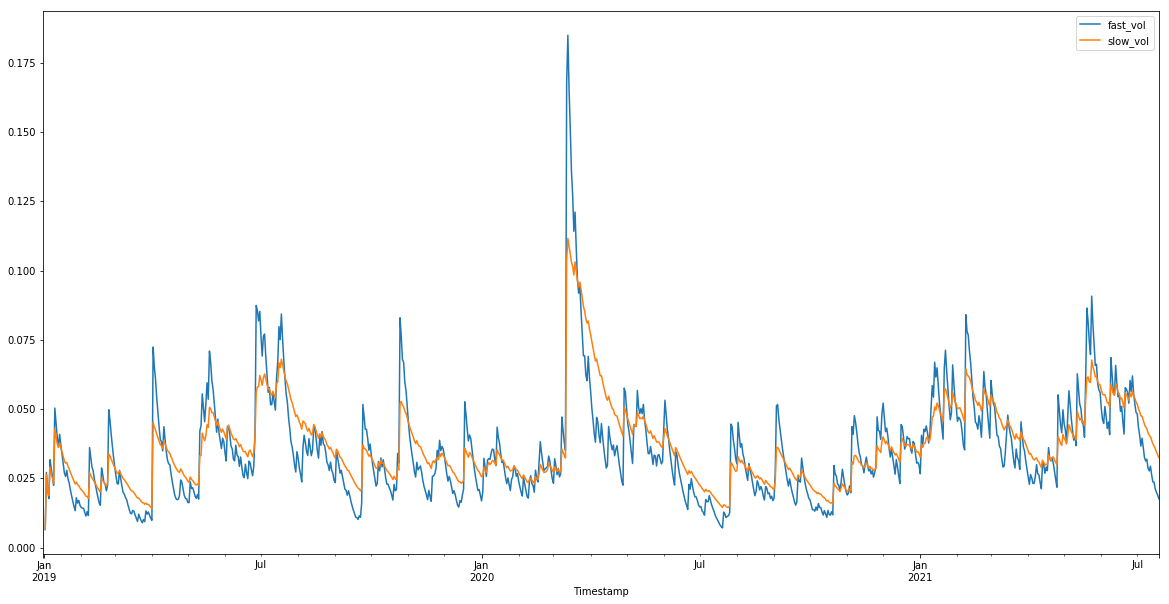

In [73]:
# Plot EMA of BTC/USD daily return volatility
btc_df[["fast_vol", "slow_vol"]].plot(figsize=(20,10))

### Bollinger Bands Indicator

In [74]:
# Set bollinger band window
bollinger_window = 20

# Rolling mean and standard deviation
btc_df["bollinger_mid_band"] = btc_df["Close"].rolling(window=bollinger_window).mean()
btc_df["bollinger_std"] = btc_df["Close"].rolling(window=20).std()

# Upper and lowers bands of bollinger band
btc_df["bollinger_upper_band"]  = btc_df["bollinger_mid_band"] + (btc_df["bollinger_std"] * 1)
btc_df["bollinger_lower_band"]  = btc_df["bollinger_mid_band"] - (btc_df["bollinger_std"] * 1)

# Bollinger band trading signal
btc_df["bollinger_long"] = np.where(btc_df["Close"] < btc_df["bollinger_lower_band"], 1.0, 0.0)
btc_df["bollinger_short"] = np.where(btc_df["Close"] > btc_df["bollinger_upper_band"], -1.0, 0.0)
btc_df["bollinger_signal"] = btc_df["bollinger_long"] + btc_df["bollinger_short"]

btc_df

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350,NaN,NaN,3702.900000,3702.900000,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,0.025450,NaN,3755.439428,3751.652401,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,0.016175,NaN,3797.986868,3789.784883,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,-0.023786,NaN,3787.312967,3783.422624,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,0.006698,NaN,3788.727518,3785.386039,1.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-15,32820.03,33185.25,31133.00,31880.00,51639.576353,-0.028642,-0.030287,33079.305629,34416.764349,0.0,...,1.0,0.0,1.0,33821.2280,1033.456433,34854.684433,32787.771567,1.0,0.0,1.0
2021-07-16,31874.49,32249.18,31020.00,31383.87,48499.864154,-0.015562,-0.071917,32729.538151,34213.660488,0.0,...,1.0,0.0,1.0,33776.2390,1119.884850,34896.123850,32656.354150,1.0,0.0,1.0
2021-07-17,31383.86,31955.92,31164.31,31520.07,34012.242132,0.004340,-0.059183,32480.025507,34033.278791,0.0,...,1.0,0.0,1.0,33617.2255,1204.363328,34821.588828,32412.862172,1.0,0.0,1.0


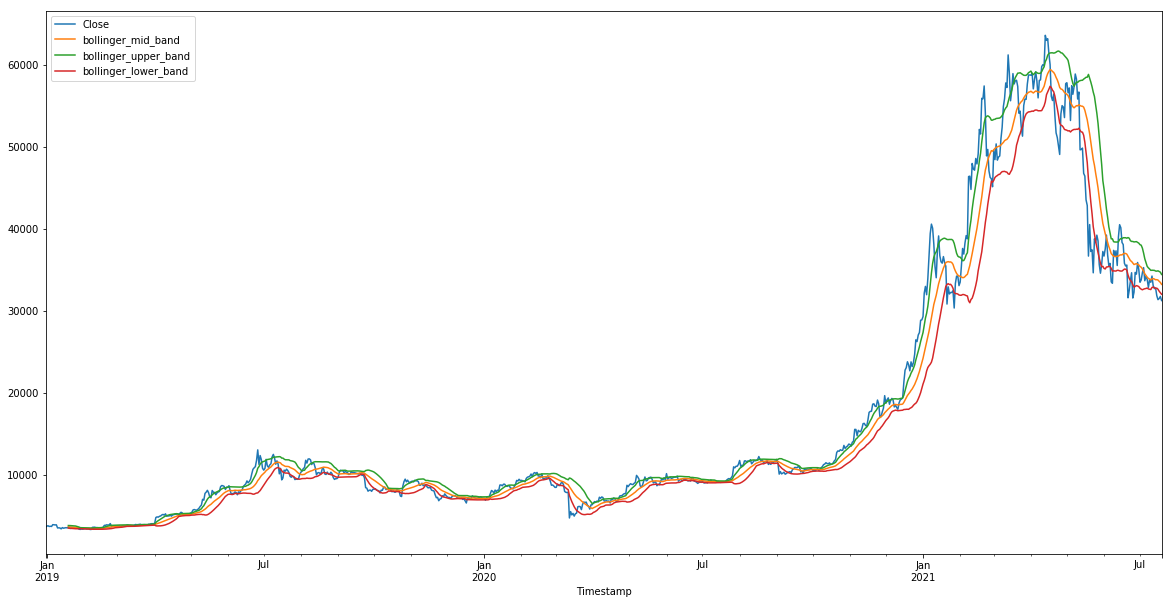

In [75]:
# Plot the Bollinger Bands for BTC/USD closing prices
btc_df[["Close","bollinger_mid_band","bollinger_upper_band","bollinger_lower_band"]].plot(figsize=(20,10))

### RSI Indicator

In [76]:
# Set up RSI Indicator for Random Forest - using btc_df
btc_df['rsi'] = momentum.RSIIndicator(btc_df['Close'],window=14).rsi()

In [77]:
raw_df.head(5)

,Open,High,Low,Close,Volume
Timestamp,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671


In [78]:
# note from below is using raw_df same as btc_df but copied for evaluating this indicator/ signal
df = raw_df.copy()

df['rsi'] = momentum.RSIIndicator(df['Close'],window=14).rsi()

df['position'] = 0
pos = 0

for idx,row in df.iterrows():
    
    rsi = row['rsi']
    
    if rsi < 20:
        # Opening Long
        df.loc[idx,'position'] = 1
    elif rsi > 80:
        # Opening Short
        df.loc[idx,'position'] = -1
        
    elif rsi < 60 and pos == - 1:
        # Closing Short
        df.loc[idx,'position'] = 0
        
    elif rsi > 40 and pos == 1:
        # Closing Long
        df.loc[idx,'position'] = 0
    else:
        df.loc[idx,'position'] = pos
        
    # Update my position for next iteration of loop
    pos = df.loc[idx,'position']
        
df['Entry/Exit'] = df['position'].diff(1).fillna(0)

In [79]:
initial_capital = 10000
size = 1.0

df['Portfolio Holdings'] = size * df['Close'] * df['Entry/Exit'].cumsum()
df['Portfolio Cash'] = initial_capital - (size * df['Close'] * df['Entry/Exit']).cumsum()
df['Portfolio Total'] = df['Portfolio Holdings']  + df['Portfolio Cash']
df['Portfolio Returns'] = df['Portfolio Total'].pct_change()
df['Portolio Cumulative Returns'] = (1 + df['Portfolio Returns']).cumprod() - 1

df.tail(5)

,Open,High,Low,Close,Volume,rsi,position,Entry/Exit,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Returns,Portolio Cumulative Returns
Timestamp,,,,,,,,,,,,,
2021-07-15,32820.03,33185.25,31133.00,31880.00,51639.576353,40.411624,0,0.0,0.0,10324.14,10324.14,0.0,0.032414
2021-07-16,31874.49,32249.18,31020.00,31383.87,48499.864154,38.862408,0,0.0,0.0,10324.14,10324.14,0.0,0.032414
2021-07-17,31383.86,31955.92,31164.31,31520.07,34012.242132,39.547558,0,0.0,0.0,10324.14,10324.14,0.0,0.032414
2021-07-18,31520.07,32435.00,31108.97,31778.56,35923.716186,40.901212,0,0.0,0.0,10324.14,10324.14,0.0,0.032414
2021-07-19,31778.57,31899.00,31261.10,31278.30,14279.347955,39.077496,0,0.0,0.0,10324.14,10324.14,0.0,0.032414


In [80]:
def plot_strategy(df):
    # Visualize exit position relative to total portfolio value
    exit = df[df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
        color='red',
        legend=False,
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Visualize entry position relative to total portfolio value
    entry = df[df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
        color='green',
        legend=False,
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Visualize total portoflio value for the investment
    total_portfolio_value = df[['Portfolio Total']].hvplot(
        line_color='lightgray',
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Overlay plots
    portfolio_entry_exit_plot = total_portfolio_value * entry * exit
    return portfolio_entry_exit_plot.opts(xaxis=None)

In [81]:
plot_strategy(df)

:Overlay
   .Curve.I                    :Curve   [Timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Timestamp]   (Portfolio Total)

### Strategy Evaluation - RSI

In [82]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Review']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest`
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [83]:
#Pull in data for each field
portfolio_evaluation_df.loc['Cumulative Returns'] = df['Portolio Cumulative Returns'][-1]
portfolio_evaluation_df.loc['Annual Return'] = df['Portfolio Returns'].mean()
portfolio_evaluation_df.loc['Annual Volatility'] = df['Portfolio Returns'].std() * np.sqrt(365)
portfolio_evaluation_df.loc['Sharpe Ratio'] =  portfolio_evaluation_df.loc['Annual Return'] / portfolio_evaluation_df.loc['Annual Volatility']

# Sortino Ratio
sortino_ratio_df = df[['Portfolio Returns']].copy()
sortino_ratio_df['Downside Returns'] = 0
target = 0
mask = sortino_ratio_df['Portfolio Returns'] < target
sortino_ratio_df.loc[mask,'Downside Returns'] = sortino_ratio_df.loc[mask,'Portfolio Returns']**2
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(365 * 24)
portfolio_evaluation_df.loc['Sortino Ratio'] =  portfolio_evaluation_df.loc['Annual Return'] / down_stdev

portfolio_evaluation_df

,Review
Annual Return,0.005202
Cumulative Returns,0.032414
Annual Volatility,3.248498
Sharpe Ratio,0.001601
Sortino Ratio,0.000796


In [84]:
# Can be used to check and compare against the other indicators
def evaluate_strategy(df):
    # Prepare DataFrame for metrics
    metrics = [
        'Annual Return',
        'Cumulative Returns',
        'Annual Volatility',
        'Sharpe Ratio',
        'Sortino Ratio']

    columns = ['Review']

    # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
    portfolio_evaluation_df.loc['Cumulative Returns'] = df['Portolio Cumulative Returns'][-1]
    portfolio_evaluation_df.loc['Annual Return'] = df['Portfolio Returns'].mean()
    portfolio_evaluation_df.loc['Annual Volatility'] = df['Portfolio Returns'].std() * np.sqrt(365)
    portfolio_evaluation_df.loc['Sharpe Ratio'] =  portfolio_evaluation_df.loc['Annual Return'] / portfolio_evaluation_df.loc['Annual Volatility']

    # Sortino Ratio
    sortino_ratio_df = df[['Portfolio Returns']].copy()
    sortino_ratio_df['Downside Returns'] = 0
    target = 0
    mask = sortino_ratio_df['Portfolio Returns'] < target
    sortino_ratio_df.loc[mask,'Downside Returns'] = sortino_ratio_df.loc[mask,'Portfolio Returns']**2
    down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(365 * 24)
    portfolio_evaluation_df.loc['Sortino Ratio'] =  portfolio_evaluation_df.loc['Annual Return'] / down_stdev
    
    return portfolio_evaluation_df

In [85]:
evaluate_strategy(df)

,Review
Annual Return,0.005202
Cumulative Returns,0.032414
Annual Volatility,3.248498
Sharpe Ratio,0.001601
Sortino Ratio,0.000796


In [86]:
from bokeh.models import Range1d, LinearAxis
from bokeh.models.renderers import GlyphRenderer

# Visualize exit position relative to Close price
exit = df[df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = df[df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize RSI - overlay onto secondary axis
def apply_formatter(plot, element):
    p = plot.state
    
    # create secondary range and axis
    p.extra_y_ranges = {"twiny": Range1d(start=0, end=100)}
    p.add_layout(LinearAxis(y_range_name="twiny"), 'right')
    glyph = p.select(dict(type=GlyphRenderer))[0]
    glyph.y_range_name = 'twiny'

RSI_indicator = df[['rsi']].hvplot(ylabel='Price in $',width=1000,height=400).opts(hooks=[apply_formatter])

# Overlay plots
entry_exit_plot = price * RSI_indicator * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .Curve.II         :Curve   [Timestamp]   (rsi)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

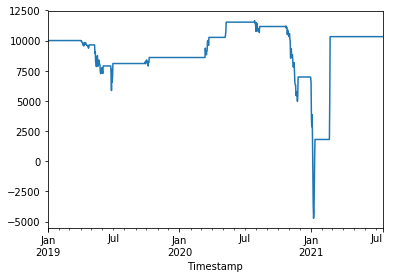

In [87]:
# Plot cumulative return of model in terms of capital
cumulative_return_capital = df['Portfolio Total']
cumulative_return_capital.plot()

# Trading Signals/ Indicators

In [88]:
trading_signals_df = btc_df.copy()

In [89]:
# Set x variable list of features
x_var_list = ["crossover_signal", "vol_trend_signal", "bollinger_signal", "rsi"]

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-07-15,-1.0,1.0,1.0,40.411624
2021-07-16,-1.0,1.0,1.0,38.862408
2021-07-17,-1.0,1.0,1.0,39.547558
2021-07-18,-1.0,1.0,1.0,40.901212
2021-07-19,-1.0,1.0,1.0,39.077496


In [90]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2018-12-31,NaN,NaN,NaN,NaN
2019-01-01,0.0,0.0,0.0,NaN
2019-01-02,1.0,0.0,0.0,NaN
2019-01-03,1.0,-1.0,0.0,NaN
2019-01-04,1.0,-1.0,0.0,NaN


In [91]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,rsi
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-14,3477.56,3671.87,3467.02,3626.09,35235.211215,0.042936,-0.087879,3671.572597,3737.896732,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,31.251957
2019-01-15,3626.08,3648.42,3516.62,3553.06,34137.997459,-0.020140,-0.101658,3646.501673,3719.425552,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,43.590937
2019-01-16,3553.06,3645.00,3543.51,3591.84,27480.179977,0.010915,-0.094490,3634.998545,3707.082513,0.0,...,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,39.825111
2019-01-17,3591.84,3634.70,3530.39,3616.21,29755.440838,0.006785,0.008458,3631.060953,3698.545416,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,42.657991
2019-01-18,3613.32,3620.00,3565.75,3594.87,22713.446755,-0.005901,-0.001788,3623.501024,3689.061406,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,44.428497


### Classification (Random Forest)

In [92]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,rsi,Positive Return
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-14,3477.56,3671.87,3467.02,3626.09,35235.211215,0.042936,-0.087879,3671.572597,3737.896732,0.0,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,31.251957,0.0
2019-01-15,3626.08,3648.42,3516.62,3553.06,34137.997459,-0.020140,-0.101658,3646.501673,3719.425552,0.0,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,43.590937,0.0
2019-01-16,3553.06,3645.00,3543.51,3591.84,27480.179977,0.010915,-0.094490,3634.998545,3707.082513,0.0,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,39.825111,0.0
2019-01-17,3591.84,3634.70,3530.39,3616.21,29755.440838,0.006785,0.008458,3631.060953,3698.545416,0.0,...,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,42.657991,1.0
2019-01-18,3613.32,3620.00,3565.75,3594.87,22713.446755,-0.005901,-0.001788,3623.501024,3689.061406,0.0,...,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,44.428497,0.0


In [93]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [94]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    371
 1    346
-1    201
Name: Positive Return, dtype: int64

In [95]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-14
Training End: 2021-01-17 00:00:00
Testing Start: 2021-01-18 00:00:00
Testing End: 2021-07-19


In [96]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-01-13,1.0,-1.0,0.0,59.892027
2021-01-14,1.0,-1.0,0.0,66.533442
2021-01-15,1.0,-1.0,-1.0,69.443489
2021-01-16,1.0,-1.0,0.0,61.625107
2021-01-17,1.0,-1.0,0.0,59.385425


Timestamp
2021-01-13    0
2021-01-14    0
2021-01-15   -1
2021-01-16   -1
2021-01-17   -1
Name: Positive Return, dtype: int64

In [97]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-07-15,-1.0,1.0,0.0,43.459703
2021-07-16,-1.0,1.0,1.0,40.411624
2021-07-17,-1.0,1.0,1.0,38.862408
2021-07-18,-1.0,1.0,1.0,39.547558
2021-07-19,-1.0,1.0,1.0,40.901212


Timestamp
2021-07-15    0
2021-07-16   -1
2021-07-17   -1
2021-07-18   -1
2021-07-19   -1
Name: Positive Return, dtype: int64

In [98]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    107
 1     41
-1     35
Name: Predicted Value, dtype: int64

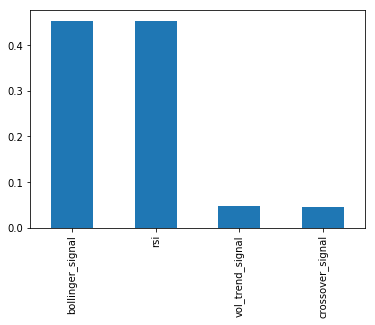

In [99]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [100]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [101]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([ 0,  0,  0,  0, -1, -1, -1, -1,  0,  0], dtype=int64)

In [102]:
results["Predicted Value"].value_counts()

 0    107
 1     41
-1     35
Name: Predicted Value, dtype: int64

In [103]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

,Positive Return,Predicted Value
Timestamp,,
2021-01-18,0,0
2021-01-19,1,0
2021-01-20,-1,0
2021-01-21,-1,0
2021-01-22,-1,-1
2021-01-23,-1,-1
2021-01-24,-1,-1
2021-01-25,-1,-1
2021-01-26,-1,0


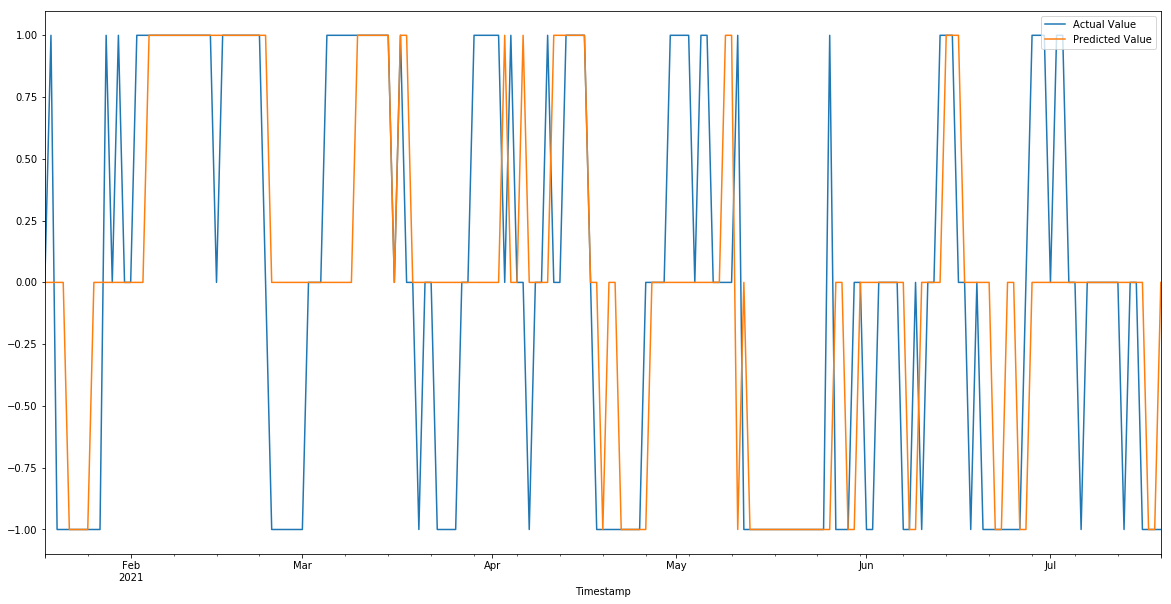

In [104]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

In [105]:
# Replace predicted values 0 to -1 to account for shorting
# results["Predicted Value"] = results["Predicted Value"].replace(0, -1)

# Display sample data
# results

### The Combined Model In Action (Results)

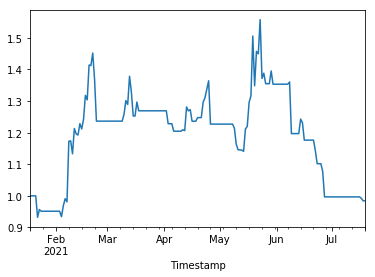

In [159]:
# Cumulative return of the model
results['Return'] = trading_signals_df['hourly_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

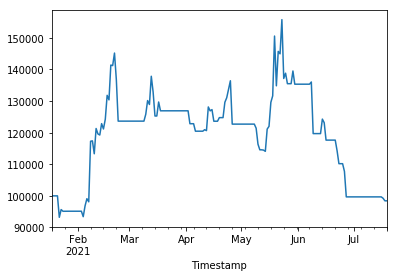

In [107]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

### Return Groupings Assessment

In [108]:
# Set up copy of main df
group_df = btc_df.copy()

In [120]:
model.predict(X_test)

array([ 0,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  0,  0, -1,  0,  0, -1, -1, -1, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,
        0,  0, -1, -1,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0], dtype=int64)

In [109]:
# Assess the confidence in each prediction in the model
results['probability'] = model.predict_proba(X_test)[:,1]

In [110]:
# Set up code for confidence levels when the return is negative vs when positive
results['pos_neg_result'] = results['Predicted Value'] * results['probability']

In [132]:
results

,Positive Return,Predicted Value,Actual Value,Return,probability,pos_neg_result,probability_quantile
Timestamp,,,,,,,
2021-01-18,0,0,0,0.022403,0.617838,0.000000,"(0.564, 0.692]"
2021-01-19,1,0,1,-0.020195,0.722506,0.000000,"(0.692, 0.767]"
2021-01-20,-1,0,-1,-0.011793,0.690479,0.000000,"(0.564, 0.692]"
2021-01-21,-1,0,-1,-0.130204,0.653416,0.000000,"(0.564, 0.692]"
2021-01-22,-1,-1,-1,0.067910,0.288653,-0.288653,"(0.206, 0.423]"
...,...,...,...,...,...,...,...
2021-07-15,0,0,0,-0.028642,0.736073,0.000000,"(0.692, 0.767]"
2021-07-16,-1,0,-1,-0.015562,0.767069,0.000000,"(0.692, 0.767]"
2021-07-17,-1,-1,-1,0.004340,0.433409,-0.433409,"(0.423, 0.564]"


In [117]:
results.groupby(by='Predicted Value').mean()

,Positive Return,Actual Value,Return,probability,pos_neg_result
Predicted Value,,,,,
-1,-0.771429,-0.771429,0.004329,0.235295,-0.235295
0,-0.056075,-0.056075,-0.003052,0.626845,0.000000
1,0.756098,0.756098,0.005799,0.230834,0.230834


In [114]:
# Looking at the results by a group (i.e. 5 in this case) and the count and mean return
results['probability_quantile'] = pd.qcut(results['probability'],5,duplicates='drop')
group_results = results.groupby('probability_quantile').agg(['count','mean'])[['Return']]
group_results

Return          
                      count      mean
probability_quantile                 
(0.0243, 0.206]          37  0.002224
(0.206, 0.423]           36  0.007405
(0.423, 0.564]           37  0.004822
(0.564, 0.692]           36  0.000694
(0.692, 0.767]           37 -0.013231

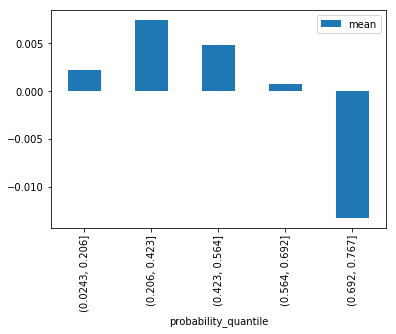

In [115]:
# Plot results - bar chart (mean)
plot_results = pd.DataFrame(group_results['Return']['mean'])
plot_results.plot.bar()

In [248]:
# Assess buy, hold, sell confidence levels
df = model.predict_proba(X_test)
df = pd.DataFrame(df)
df.columns=['-1','0','1']

Returns = []
for item in results['Return']:
    Returns.append(item)
    
df['Return'] = Returns

df.head(5)

,-1,0,1,Return
0,0.217995,0.617838,0.164166,0.022403
1,0.121702,0.722506,0.155792,-0.020195
2,0.143083,0.690479,0.166438,-0.011793
3,0.166794,0.653416,0.179790,-0.130204
4,0.680518,0.288653,0.030830,0.067910


In [249]:
del df_neg['0']
del df_neg['1']
df_neg['probability_quantile'] = pd.qcut(df_neg['-1'],5,duplicates='drop')
df_neg = df_neg.groupby('probability_quantile').agg(['count','mean'])[['Return']]
df_neg # i.e. to assess confidence when predicted it is -1, it actually is -1

Return          
                                count      mean
probability_quantile                           
(0.00013999999999999993, 0.03]     37  0.004904
(0.03, 0.164]                      36 -0.010471
(0.164, 0.226]                     38 -0.005091
(0.226, 0.413]                     35  0.003677
(0.413, 0.913]                     37  0.008731

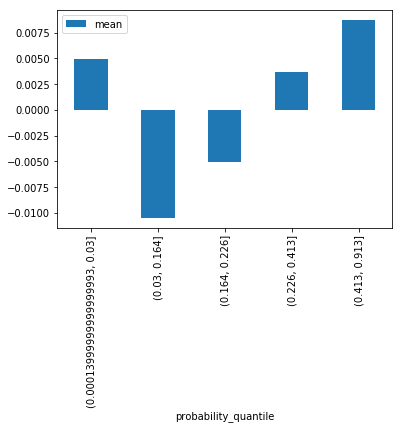

In [229]:
df_neg_plot = pd.DataFrame(df_neg['Return']['mean'])
df_neg_plot.plot.bar()

In [251]:
df = model.predict_proba(X_test)
df = pd.DataFrame(df)
df.columns=['-1','0','1']

Returns = []
for item in results['Return']:
    Returns.append(item)
    
df['Return'] = Returns

df_pos = pd.DataFrame(df)
del df_pos['-1']
del df_pos['0']
df_pos['probability_quantile'] = pd.qcut(df_pos['1'],5,duplicates='drop')
df_pos = df_pos.groupby('probability_quantile').agg(['count','mean'])[['Return']]
df_pos

Return          
                                count      mean
probability_quantile                           
(0.015199999999999998, 0.0779]     37  0.008820
(0.0779, 0.119]                    36 -0.006391
(0.119, 0.18]                      37 -0.005756
(0.18, 0.582]                      37 -0.002671
(0.582, 0.974]                     36  0.007730

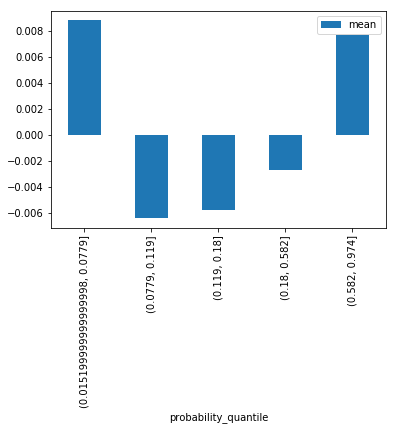

In [254]:
df_pos_plot = pd.DataFrame(df_pos['Return']['mean'])
df_pos_plot.plot.bar()

In [253]:
df = model.predict_proba(X_test)
df = pd.DataFrame(df)
df.columns=['-1','0','1']

Returns = []
for item in results['Return']:
    Returns.append(item)
    
df['Return'] = Returns

df_neutral = pd.DataFrame(df)
del df_neutral['-1']
del df_neutral['1']
df_neutral['probability_quantile'] = pd.qcut(df_neutral['0'],5,duplicates='drop')
df_neutral = df_neutral.groupby('probability_quantile').agg(['count','mean'])[['Return']]
df_neutral

Return          
                      count      mean
probability_quantile                 
(0.0243, 0.206]          37  0.002224
(0.206, 0.423]           36  0.007405
(0.423, 0.564]           37  0.004822
(0.564, 0.692]           36  0.000694
(0.692, 0.767]           37 -0.013231

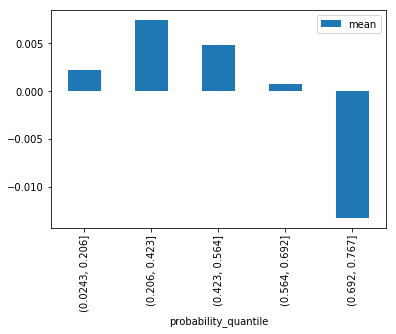

In [255]:
df_neutral_plot = pd.DataFrame(df_neutral['Return']['mean'])
df_neutral_plot.plot.bar()